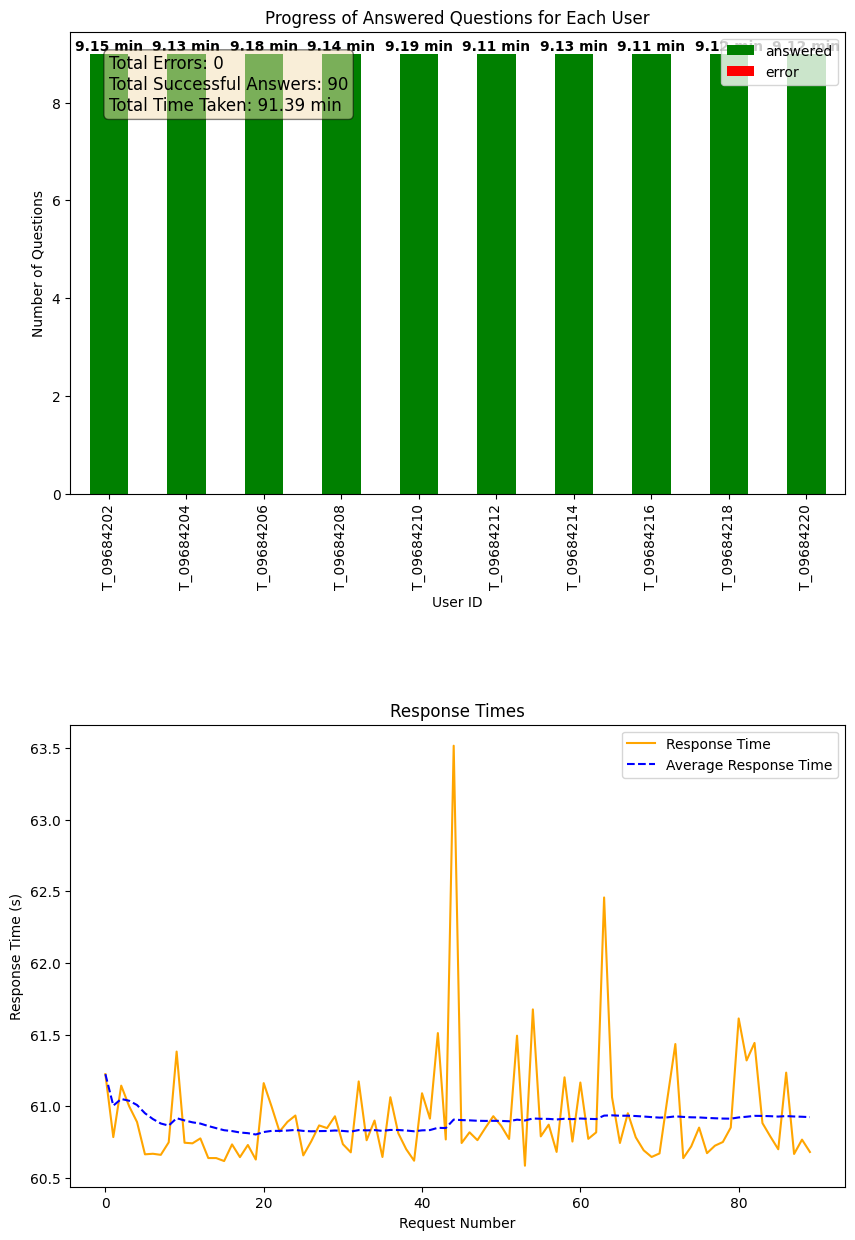

Volume testing completed with 10 users and 9 questions.


c:\Users\W513032\source\repos\volume testing\.venv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
c:\Users\W513032\source\repos\volume testing\.venv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(



LLM Analysis and Recommendations:

 Insights:
    - The test results show that the API has a high success rate, with 90 successful answers out of 99 attempts.
    - The total time taken is 91.39 minutes, which is relatively long. This could be due to various factors such as network latency, server load, or inefficient code.
    - The average response time is 60.89 seconds, which is relatively high. This could be due to the same factors mentioned above.
    - There are no errors reported in the error log, which is a good sign.
    - The maximum response time is 63.52 seconds, which is relatively high. This could be a sign of a bottleneck or a slow-down in the system.
    - The minimum response time is 60.58 seconds, which is relatively low. This could be due to the system being able to handle some requests quickly.
    
    Recommendations for Improvement:
    - Optimize the code for better performance. This could include caching frequently accessed data, using efficient algorithms, or

In [1]:
import os
import tempfile
import pandas as pd
import random
import requests
import time
import certifi
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display, clear_output
from threading import Lock
from datetime import datetime
from langchain_community.llms import Bedrock
from langchain_aws import BedrockLLM
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import sys
import boto3
import urllib3

# suppress warnings are due to making HTTPS requests to localhost without verifying SSL certificates. 
# Suppress only the single InsecureRequestWarning from urllib3 needed
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Set the AWS profile and certificate bundle
os.environ["AWS_PROFILE"] = "default"
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# Create a temporary directory for storing the uploaded files
temp_dir = tempfile.TemporaryDirectory()

# Set the model ID
model_id = "meta.llama3-8b-instruct-v1:0"

def validate_file(file_path):
    """
    Validates the uploaded file to ensure it can be read as an Excel file.
    
    Parameters:
    - file_path: str, path to the file to be validated
    
    Returns:
    - Tuple (bool, int): True if the file is valid, and the number of rows in the file
    """
    try:
        df = pd.read_excel(file_path)
        return True, df.shape[0]
    except Exception as e:
        return False, 0

def validate_token(token):
    """
    Validates the Bearer token by making a test API call.
    
    Parameters:
    - token: str, the Bearer token
    
    Returns:
    - bool: True if the token is valid, False otherwise
    """
    url = 'https://localhost:8443/v1.0/benefitassistant/Assistant/llm-response?question=test'
    headers = {
        'accept': '*/*',
        'Authorization': f'Bearer {token}'
    }
    try:
        response = requests.get(url, headers=headers, verify=False)  # verify=False for local testing, remove in production
        return response.status_code == 200
    except requests.exceptions.RequestException:
        return False

def chat(question, token):
    """
    Sends a question to the API and returns the response.
    
    Parameters:
    - question: str, the question to be sent
    - token: str, the authorization token for the API
    
    Returns:
    - response: dict, the response from the API
    """
    """ check bearer token for validity - we wil ldo it lates fo ra quicker API
    if not validate_token(token):
        print("Error: Invalid Bearer token.")
        sys.exit(1)
    """
    
    url = f'https://localhost:8443/v1.0/benefitassistant/Assistant/llm-response?question={question}'
    headers = {
        'accept': '*/*',
        'Authorization': f'Bearer {token}'
    }
    try:
        response = requests.get(url, headers=headers, verify=False)  # verify=False for local testing, remove in production
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        return {"error": str(e)}

def simulate_user_questions(user_id, questions, question_ids, user_progress, user_time, response_times, avg_response_times, error_log, lock, results, token, start_time):
    """
    Simulates a user asking questions and updates the progress.
    
    Parameters:
    - user_id: str, ID of the user
    - questions: list, list of questions to ask
    - question_ids: list, list of question IDs corresponding to the questions
    - user_progress: dict, dictionary to store user progress
    - user_time: dict, dictionary to store time taken by the user
    - response_times: list, list to store response times for each question
    - avg_response_times: list, list to store average response times for each question
    - error_log: list, list to store error messages
    - lock: threading.Lock, lock to synchronize access to shared resources
    - results: list, list to store results for the Excel file
    - token: str, the authorization token for the API
    - start_time: float, the start time of the first question submission
    """
    combined = list(zip(question_ids, questions))
    random.shuffle(combined)
    for question_id, question in combined:
        try:
            start_time_question = time.time()
            response = chat(question, token)
            end_time_question = time.time()
            time_taken = end_time_question - start_time_question
            user_time[user_id] += time_taken
            response_times.append(time_taken)
            avg_response_times.append(sum(response_times) / len(response_times))
            
            if "error" in response:
                raise Exception(response["error"])
            
            answer = response.get("answer", "")
            user_progress[user_id]["answered"] += 1
            results.append([user_id, question, answer, ""])
        except Exception as e:
            error_info = f"Error occurred for user {user_id}, question ID {question_id}, question: {question}. Error: {str(e)}"
            error_log.append(error_info)
            user_progress[user_id]["error"] += 1
            results.append([user_id, question, "", str(e)])

        with lock:
            update_plot(user_progress, user_time, response_times, avg_response_times, error_log, start_time)

def update_plot(user_progress, user_time, response_times, avg_response_times, error_log, start_time):
    """
    Updates the plot showing the progress of users and other metrics.
    
    Parameters:
    - user_progress: dict, dictionary containing progress of users
    - user_time: dict, dictionary containing time taken by users
    - response_times: list, list of response times
    - avg_response_times: list, list of average response times
    - error_log: list, list of error messages
    - start_time: float, the start time of the first question submission
    """
    progress_df = pd.DataFrame(user_progress).T
    fig, axes = plt.subplots(2, 1, figsize=(10, 15))

    # Adjust layout to add space between the plots
    plt.subplots_adjust(hspace=0.5)

    # Plot progress of answered questions for each user
    progress_df.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
    axes[0].set_xlabel('User ID')
    axes[0].set_ylabel('Number of Questions')
    axes[0].set_title('Progress of Answered Questions for Each User')
    axes[0].yaxis.get_major_locator().set_params(integer=True)

    # Annotate the bars with the time taken
    for p in axes[0].patches:
        width, height = p.get_width(), p.get_height()
        if height > 0:
            x, y = p.get_xy()
            user_id = progress_df.index[int(x + width / 2)]
            if user_progress[user_id]["answered"] > 0:  # Annotate only once per user
                time_text = f"{user_time[user_id] / 60:.2f} min"
                axes[0].annotate(time_text, (x + width / 2, height), 
                                 ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    # Calculate total elapsed time
    total_time_taken = (time.time() - start_time) / 60  # in minutes

    # Display number of errors, successful answers, and total time taken
    total_errors = sum(user['error'] for user in user_progress.values())
    total_successes = sum(user['answered'] for user in user_progress.values())
    textstr = f'Total Errors: {total_errors}\nTotal Successful Answers: {total_successes}\nTotal Time Taken: {total_time_taken:.2f} min'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=12,
                 verticalalignment='top', bbox=props)

    # Plot response times and average response times
    axes[1].plot(response_times, label='Response Time', color='orange')
    axes[1].plot(avg_response_times, label='Average Response Time', linestyle='--', color='blue')
    axes[1].set_xlabel('Request Number')
    axes[1].set_ylabel('Response Time (s)')
    axes[1].set_title('Response Times')
    axes[1].legend()

    clear_output(wait=True)
    display(fig)
    plt.close(fig)

def analyze_results(user_count, question_count, total_successes, total_errors, total_time_taken, avg_response_times, response_times, error_log):
    """
    Analyzes the volume test results using the Bedrock LLM.
    
    Parameters:
    - user_count: int, number of users
    - question_count: int, number of questions
    - total_successes: int, total successful answers
    - total_errors: int, total errors
    - total_time_taken: float, total time taken for the volume test
    - avg_response_times: list, average response times for each request
    - response_times: list, response times for each request
    - error_log: list, list of error messages
    
    Returns:
    - analysis: str, analysis provided by the LLM
    """
    results_summary = f"""
    Volume Testing Results Summary:
    - Number of users: {user_count}
    - Number of questions: {question_count}
    - Total Successful Answers: {total_successes}
    - Total Errors: {total_errors}
    - Total Time Taken: {total_time_taken:.2f} minutes
    - Average Response Time: {sum(avg_response_times) / len(avg_response_times):.2f} seconds
    - Maximum Response Time: {max(response_times):.2f} seconds
    - Minimum Response Time: {min(response_times):.2f} seconds
    
    Error Log:
    {error_log}
    """
    
    question = f"""
    We are testing an API. Please analyze the following volume test results and provide insights on what is good, what problems exist, and how to improve performance if there are any issues.
    
    {results_summary}
    """
    
    prompt = PromptTemplate(
        input_variables=["question"],
        template="{question}"
    )

    bedrock_chain = LLMChain(llm=llm, prompt=prompt)
    response = bedrock_chain({'question': question})
    return response['text']

# Placeholder for user input file paths
users_file_path = "wex-users.xlsx"  # Replace with the actual path
questions_file_path = "wex-questions.xlsx"  # Replace with the actual path

# Define your Bearer token here
auth_token = "eyJhbGciOiJSUzI1NiIsImtpZCI6IjEzNDAxMURGMjAwRENGOTlCN0M2RkMzMDNFMEQ4REVBMUM5QjYzRjAiLCJ0eXAiOiJKV1QiLCJ4NXQiOiJFMEFSM3lBTno1bTN4dnd3UGcyTjZoeWJZX0EifQ.eyJuYmYiOjE3MTY4NDMwNjIsImV4cCI6MTcxNjg0Mzk2MiwiaXNzIjoiaHR0cHM6Ly9kdi1pZC5teWJlbmVmaXRleHByZXNzLmNvbSIsImF1ZCI6WyJodHRwczovL2R2LWlkLm15YmVuZWZpdGV4cHJlc3MuY29tL3Jlc291cmNlcyIsImFwaSJdLCJjbGllbnRfaWQiOiJtYmU1MCIsInN1YiI6Ijk2ODMyOTEiLCJhdXRoX3RpbWUiOjE3MTY4NDMwNjIsImlkcCI6ImxvY2FsIiwibmFtZSI6IlRfMDk2ODMyOTEiLCJ0ZW5hbnRfaWQiOiIxMTMwIiwibG9nZ2VkX2luX3RlbmFudF9pZCI6IjExMzAiLCJ1c2VyaWQiOiI5NjgzMjkxIiwiU2Vzc2lvbmlkIjoiSW50ZXJuYWwtNmJiNDQ4ZjEtNGI4My00Y2Y2LTg0YjEtYjU3Y2QyNjIyNDE5Iiwic2NvcGUiOlsib3BlbmlkIiwibWJlIl0sImFtciI6WyJwd2QiXX0.WkaZ-yNsTfGZm72gi7WWPtZcqXtNOKj98Qs6VLUqsZq0nLMWT9yN4UFAvWQilVhYZSXxn9sZFtmYp8t0UqQIMy9yRBRlHx2VUlDt8usSqX928qNDMQVY3slTaBY8Y6KWXMVoAvbYfIHiZu8SMSLUFDj1lYFrazH5dWqECgtd6XIq24txVFNOy0LXmnUvQ7_KSgRmyADynDc0jZc0yfquNf_r3lWuumO3AhBRfnB4Wml2jocSiqJg88Y3FaK9SRlbmIvzvdWbI5sCxxh3um9T7TIG5sUDRTRU9z2UZncGib1kVWn2r_a3FDuBCOiKlRTZeGRIPYl5gsGhUUv32MhsGw"  # Replace with the actual token

# Validate the files
is_users_valid, user_count = validate_file(users_file_path)
is_questions_valid, question_count = validate_file(questions_file_path)

error_log = []
response_times = []
avg_response_times = []
results = []

if is_users_valid and is_questions_valid:
    users = pd.read_excel(users_file_path)
    questions_df = pd.read_excel(questions_file_path)

    if 'Question' not in questions_df.columns or 'question-id' not in questions_df.columns:
        print("Error: The 'question-id' and/or 'Question' column is not found in the questions file.")
        print(f"Available columns are: {questions_df.columns.tolist()}")
    elif 'user-id' not in users.columns:
        print("Error: The 'user-id' column is not found in the users file.")
        print(f"Available columns are: {users.columns.tolist()}")
    else:
        questions = questions_df["Question"].tolist()
        question_ids = questions_df["question-id"].tolist()
        user_ids = users["user-id"].tolist()

        print(f"Number of user records: {user_count}")
        print(f"Number of questions: {question_count}")

        user_progress = {user_id: {"answered": 0, "error": 0} for user_id in user_ids}
        user_time = {user_id: 0 for user_id in user_ids}
        lock = Lock()

        bedrock_client = boto3.client(
            service_name="bedrock-runtime",
            region_name="us-east-1"
        )

        llm = BedrockLLM(
            model_id=model_id,
            client=bedrock_client,
            model_kwargs={"max_gen_len": 512, "temperature": 0.5}
        )

        start_time = time.time()  # Capture the start time

        with ThreadPoolExecutor(max_workers=len(user_ids)) as executor:
            futures = []
            for user_id in user_ids:
                futures.append(executor.submit(simulate_user_questions, user_id, questions, question_ids, user_progress, user_time, response_times, avg_response_times, error_log, lock, results, auth_token, start_time))
                time.sleep(5)

            for future in as_completed(futures):
                future.result()

        total_time_taken = (time.time() - start_time) / 60  # Calculate the total elapsed time

        print(f"Volume testing completed with {user_count} users and {question_count} questions.")
        if error_log:
            print("Errors occurred during volume testing. Here are the details:")
            for error in error_log:
                print(error)

        # Analyze the results using the LLM
        total_successes = sum(user['answered'] for user in user_progress.values())
        total_errors = sum(user['error'] for user in user_progress.values())
        analysis = analyze_results(len(user_ids), len(questions), total_successes, total_errors, total_time_taken, avg_response_times, response_times, error_log)
        print("\nLLM Analysis and Recommendations:\n")
        print(analysis)

        # Save results to an Excel file
        results_df = pd.DataFrame(results, columns=['user-id', 'question', 'answer', 'error'])
        timestamp = datetime.now().strftime('%Y%m%d-%H%M')
        results_df.to_excel(f'volume-test-run-{timestamp}.xlsx', index=False)
        print(f"Results saved to volume-test-run-{timestamp}.xlsx")
else:
    print("One or both of the uploaded files are not valid Excel files.")





